In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 3a - Coupled 2-box with vertical diffusion

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [2]:
# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 0.3         # Noise strength

# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 2

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}

# Iterate over set of experiments
for i, exp in enumerate(experiments):
  full_outputs_ensemble[exp], forcings_ensemble[exp], T_out_ensemble[exp] = [], [] ,[]

  # Run deterministic experiments once
  full_outputs_single[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i, vert_diff_flag=1, n_boxes=n_boxes)
  forcings_single[exp] = np.tile(full_outputs_single[exp]['forcing_ts'], (n_boxes, 1))
  T_out_single[exp] = np.squeeze(full_outputs_single[exp]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[exp].append(BudykoSellers.Run_Budyko_Sellers(exp_flag=i, vert_diff_flag=1, xi=xi, n_boxes=n_boxes))
    forcings_ensemble[exp].append(np.tile(full_outputs_ensemble[exp][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[exp].append(np.squeeze(full_outputs_ensemble[exp][-1]['T_ts'])[0:n_boxes,:])


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


In [3]:
for exp in experiments:
  forcings_single[exp][1] = np.zeros(len(forcings_single[exp][1]))
  for i in range(len(forcings_ensemble[exp])):
    forcings_ensemble[exp][i][1] = np.zeros(len(forcings_ensemble[exp][i][1]))

### Method X: DMD

In [4]:
n_choices = 10
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1

operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_experiments('DMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
operator_ensemble_DMD, operator_L2_avg_DMD, w_pred_L2_DMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'DMD', operator_DMD, w0=w0, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.01174056126659643
	Test: High Emissions - 0.3129948808417992
	Test: Overshoot - 0.19266718527096546
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.6070566287407358
	Test: High Emissions - 0.00018437475070408606
	Test: Overshoot - 0.289814409421399
Train: Overshoot - L2 Error
	Test: 2xCO2 - 0.40228948988088736
	Test: High Emissions - 0.007718114426322431
	Test: Overshoot - 0.004754679386162812


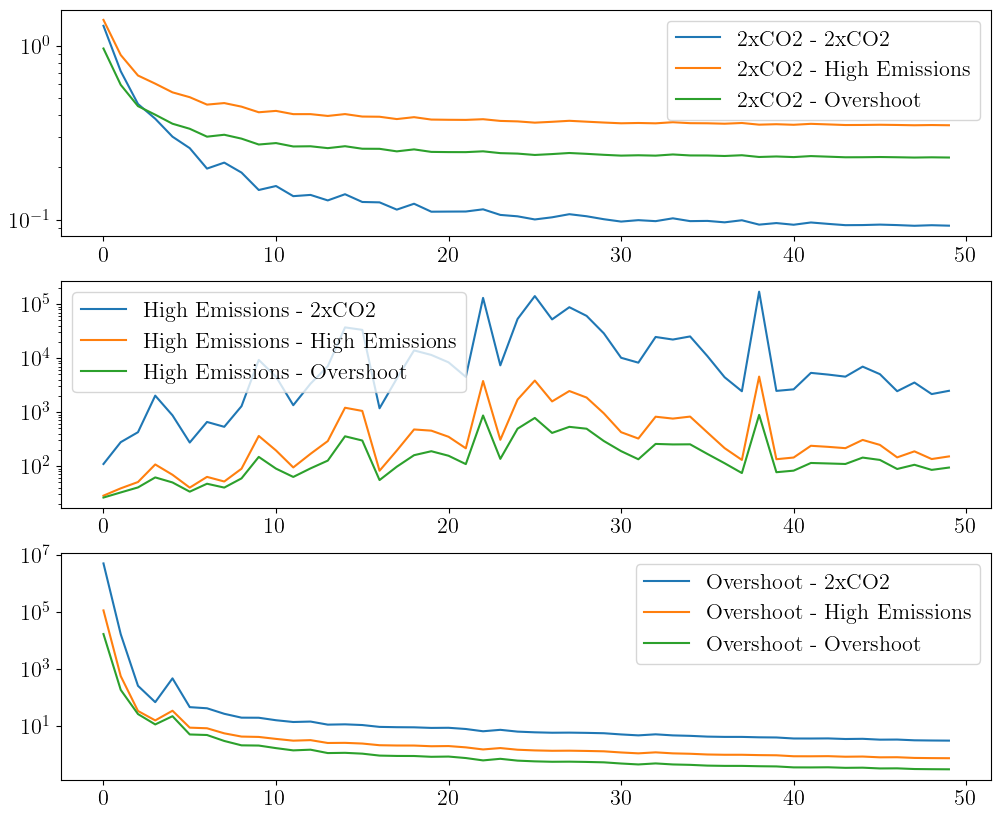

In [5]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_DMD[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: EDMD

In [6]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_experiments('EDMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
#emulator_utils.plot_true_pred(T_out_single, T_pred_EDMD, experiments)
operator_ensemble_EDMD, operator_L2_avg_EDMD, w_pred_L2_EDMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'EDMD', operator_EDMD, w_dict=w_dict, F_dict=F_dict, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.010786437160008181
	Test: High Emissions - 14.543940830590524
	Test: Overshoot - 4.877470645849224
Train: High Emissions - L2 Error
	Test: 2xCO2 - 10.809136426711715
	Test: High Emissions - 0.00016886095882161288
	Test: Overshoot - 2.04481323477088
Train: Overshoot - L2 Error
	Test: 2xCO2 - 109.70623057787375
	Test: High Emissions - 2.690785487461903
	Test: Overshoot - 0.12550595167497697


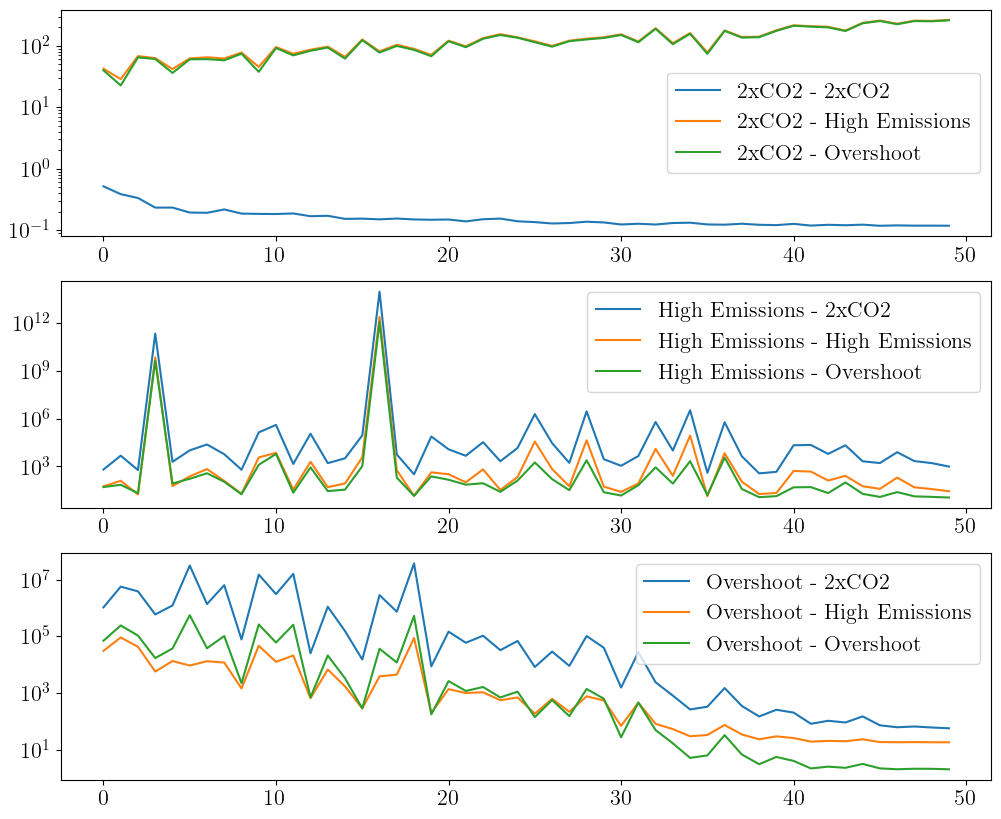

In [7]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_EDMD[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: Deconvolution

In [8]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_experiments('deconvolve', experiments=experiments, outputs=T_out_single, forcings=forcings_single, dt=dt)
#emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)
operator_ensemble_deconvolve, operator_L2_avg_deconvolve, w_pred_L2_deconvolve = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'deconvolve', operator_deconvolve, dt=dt)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 2.5700432227947362e-14
	Test: High Emissions - 0.30465557178819325
	Test: Overshoot - 0.18684398098440974
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.5938969151638678
	Test: High Emissions - 2.1959045202441585e-14
	Test: Overshoot - 0.2801299148812935
Train: Overshoot - L2 Error
	Test: 2xCO2 - 388883.3389637226
	Test: High Emissions - 6252.852543361017
	Test: Overshoot - 2.5362765584796365e-14


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


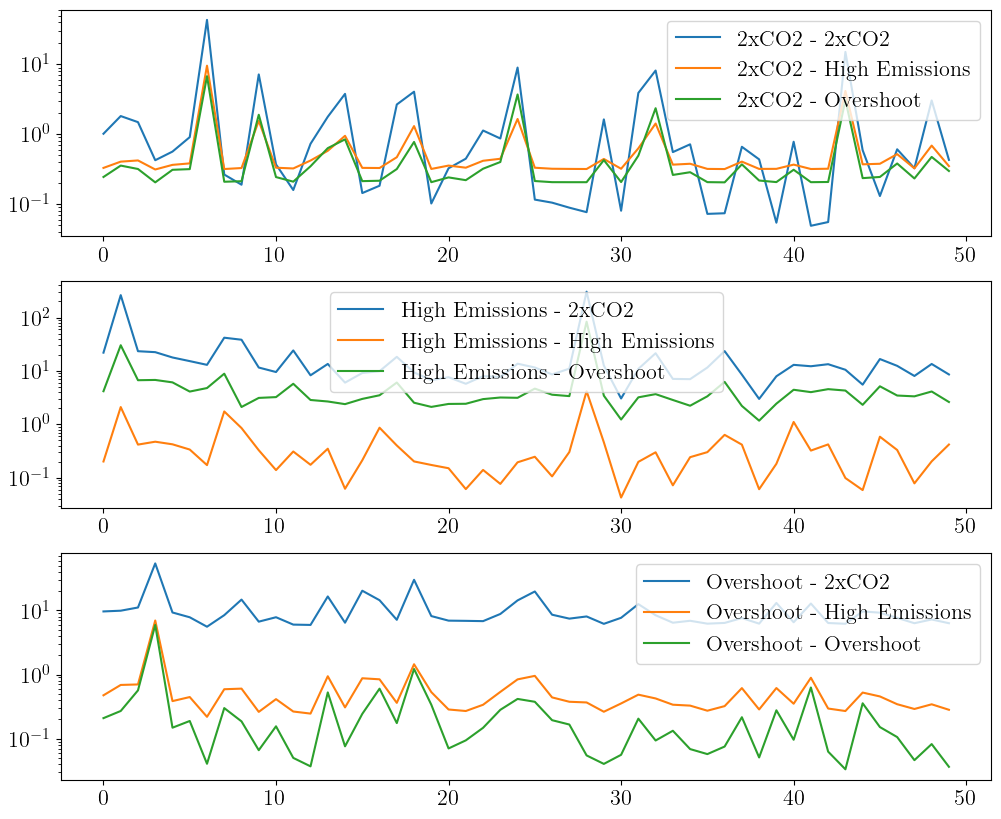

In [9]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_deconvolve[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: Direct Diagnosis (FDT)

In [10]:
n_ensemble = 10
operator_FDT, T_pred_FDT, L2_FDT = [], [], []
delta = 2
for n in range(1,n_ensemble + 1):
  operator_FDT_n, T_pred_FDT_n, L2_FDT_n = emulator_utils.emulate_experiments('FDT', experiments=experiments, forcings=forcings_single, outputs=T_out_single, n_ensemble=n, n_boxes=n_boxes, n_steps=n_steps, xi=xi, delta=delta, dt=dt)

  operator_FDT.append(operator_FDT_n)
  T_pred_FDT.append(T_pred_FDT_n)
  L2_FDT.append(L2_FDT_n)

Train: 2xCO2 - L2 Error


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


	Test: 2xCO2 - 53.68507654694804
	Test: High Emissions - 47.432827732439144
	Test: Overshoot - 37.776766333330855
Train: High Emissions - L2 Error
	Test: 2xCO2 - 44.516819940264554
	Test: High Emissions - 39.908409772686184
	Test: Overshoot - 32.002457965876275
Train: Overshoot - L2 Error
	Test: 2xCO2 - 53.7397773218348
	Test: High Emissions - 47.6917635645037
	Test: Overshoot - 37.99943421581723
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 46.50555458812291
	Test: High Emissions - 42.05353822553633
	Test: Overshoot - 33.49889490578174
Train: High Emissions - L2 Error
	Test: 2xCO2 - 51.583404712351346
	Test: High Emissions - 45.989256120641066
	Test: Overshoot - 36.15475312276571
Train: Overshoot - L2 Error
	Test: 2xCO2 - 56.95662578669909
	Test: High Emissions - 49.436567034141426
	Test: Overshoot - 39.98164789969312
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 51.29671289585424
	Test: High Emissions - 45.73079867302563
	Test: Overshoot - 36.38485207368067
Train: High Emissions - L2 Error
	Test: 

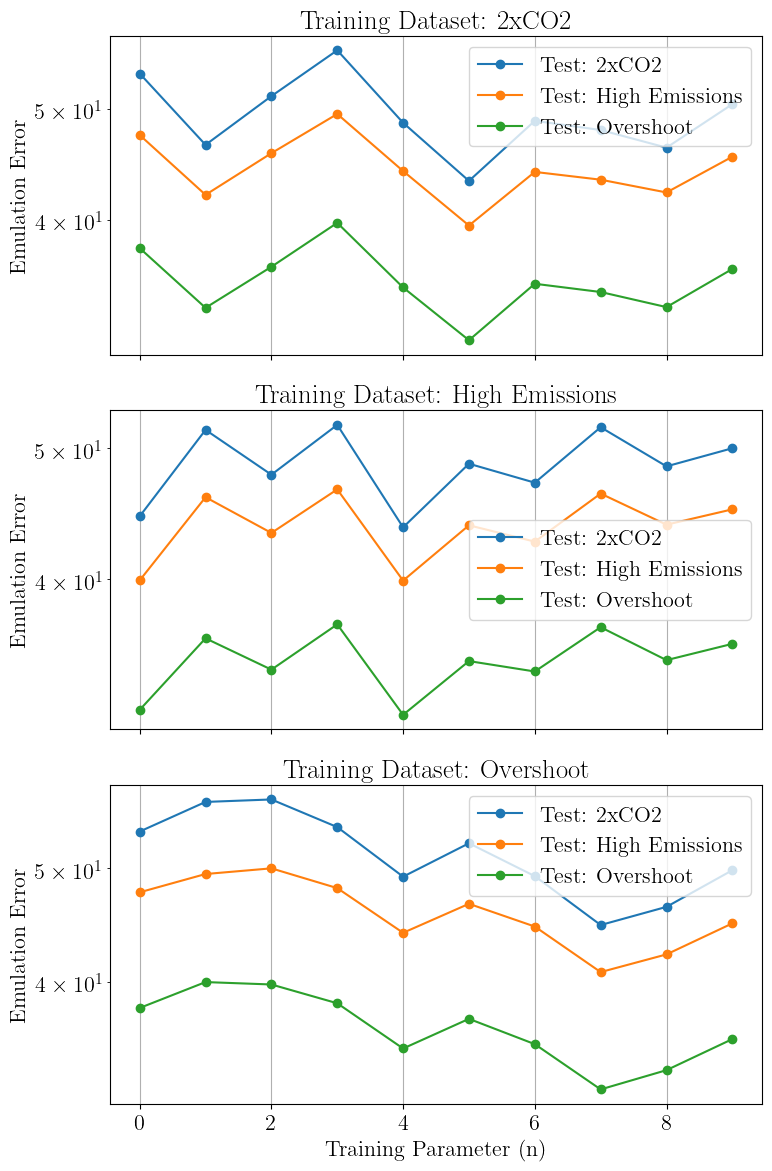

In [11]:
# Number of subplots
num_subplots = len(experiments)
n_values = np.arange(len(L2_FDT))  # Indices represent the training parameter n

# Create subplots
fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 4 * num_subplots), sharex=True)

if num_subplots == 1:
  axes = [axes]  # Ensure axes is iterable if there's only one subplot

for i, exp1 in enumerate(experiments):
  ax = axes[i]
  for exp2 in experiments:
    errors = [entry[exp1][exp2] for entry in L2_FDT]
    ax.semilogy(n_values, errors, marker='o', label=f'Test: {exp2}')

  ax.set_title(f'Training Dataset: {exp1}')
  ax.set_ylabel('Emulation Error')
  ax.legend()
  ax.grid(True)

# Common x-axis label
axes[-1].set_xlabel('Training Parameter (n)')

# Show plot
plt.tight_layout()
plt.show()

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [ 0.5636958   0.39960492 -0.00294101  0.74566847 -0.99627297 -0.00446863]
	Test: 2xCO2 - 2.2058598326210728
	Test: High Emissions - 0.29559612183917644
	Test: Overshoot - 0.8131601208684512
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.7160171   0.64643324  0.50710256 -2.2682105  -0.83465376 -1.2354605 ]
	Test: 2xCO2 - 22.239134038800238
	Test: High Emissions - 0.13195308078342752
	Test: Overshoot - 5.690631935597779
Train: Overshoot - L2 Error
Exponential Fit Results:
 [-5.45969057e+02 -6.57386505e+02  3.69119260e+02  6.51290178e+02
 -6.86816558e-01 -6.30948158e-01]
	Test: 2xCO2 - 19.583458024997356
	Test: High Emissions - 2.5847908171773786
	Test: Overshoot - 5.1948820809057725


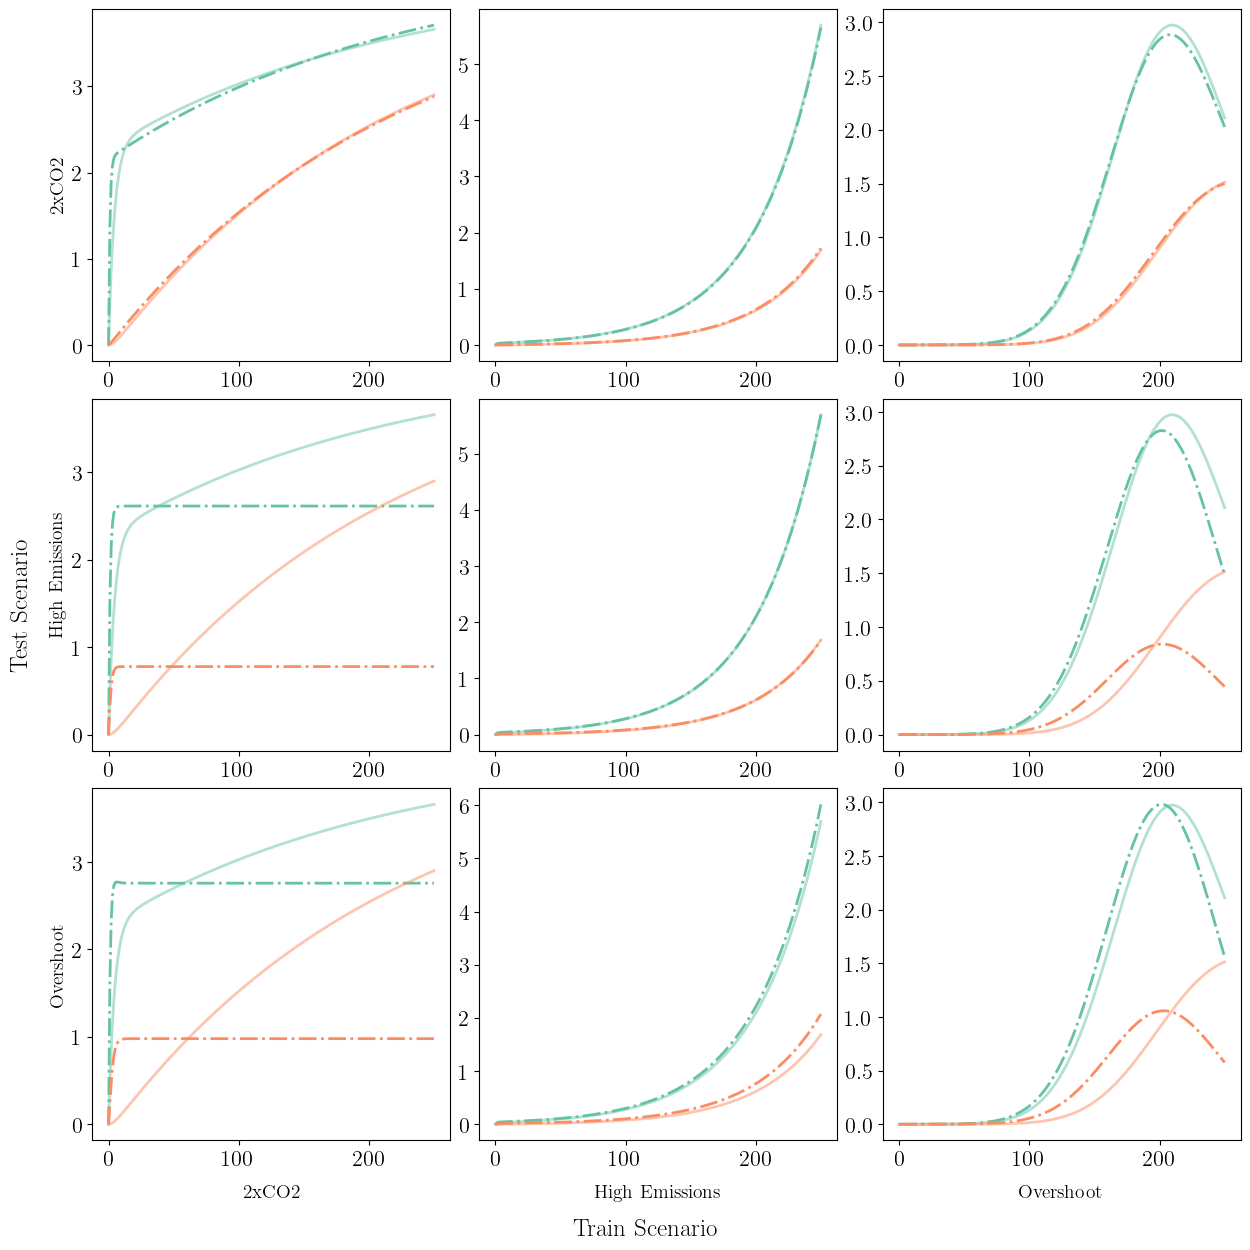

In [132]:
B=np.array([1.0, 0.0])
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2, B=B)
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)